In [44]:
import PIL
import subprocess
import re
import os
import time
import io
import cv2
import requests
import bs4
import jieba
import jieba.analyse
from IPython.display import display, HTML
import json

import pandas as pd
import sqlite3

In [2]:
%run key.py

In [3]:
from aip import AipOcr

client = AipOcr(AIP_APP_ID, AIP_API_KEY, AIP_SECRET_KEY)

In [19]:
def capture_img():
    subprocess.call('.\\adb\\adb shell /system/bin/screencap -p /sdcard/screenshot.png')
    time.sleep(0.1)
    subprocess.call('.\\adb\\adb pull /sdcard/screenshot.png %s' % './tmp/screenshot.png')
    time.sleep(0.1)
    
    return cv2.imread('./tmp/screenshot.png')


def get_text_in_region(aip_rst, region):
    s = ''
    if 'words_result' in aip_rst:
        words = []
        for p in aip_rst['words_result']:
            loc = p['location']
            if loc['top'] > region[0] and loc['top'] + loc['height'] < region[1] \
                and loc['left'] > region[2] and loc['left'] + loc['width'] < region[3]:
                if loc['left'] < 1080 / 2: # only get words that starts from left
                    words.append(p['words'])
        s = ''.join(words)
        
    if s != '':
        # remove heading, like 1. A. B.
        if re.match(r"^A|B|C|\d+\.|,|。|，", s) != None: 
            ss = re.split(r"\.|,|。|，",s)
            if len(ss) > 1:
                s = ''.join(ss[1:])
            
    return s

def ocr(im, regions):
    _, byte_arr = cv2.imencode('.jpg', im, [int(cv2.IMWRITE_JPEG_QUALITY), 90])
    aip_rst = client.general(byte_arr.tobytes())
    return [get_text_in_region(aip_rst, region) for region in regions]


def go_search(s, engine='google'):
    if engine == 'google':
        os.system('start www.google.com/search?q=%s' % s)
    elif engine == 'baidu':
        os.system('start www.baidu.com/s?wd=%s' % s)

def search(question):
    rst = requests.get('http://www.baidu.com/s?wd=%s&rn=50' % question)
    rst.encoding = 'utf-8'
    search_rst = rst.text
    
    soup = bs4.BeautifulSoup(search_rst, 'html.parser')
    rst = soup.select('div#content_left')[0]
    return rst.text

def search_advanced(question_words, opt_words, return_string=True, engine='baidu'):
    '''
    Advanced search
    question_words: list of words of the question
    opt_words: list of list of words of the options
    '''
    all_opt_words = []
    
#     for words in opt_words:
#         all_opt_words += words
        
#     all_opt_words = list(set(all_opt_words))
    
    if engine == 'baidu':
        url = 'http://www.baidu.com/s?q1=%s&q2=&q3=%s&q4=&rn=50' % (
            '+'.join(question_words),
            '+'.join(all_opt_words))
        rst = requests.get(url)
        print(url)
        rst.encoding = 'utf-8'
        search_rst = rst.text

        soup = bs4.BeautifulSoup(search_rst, 'html.parser')
        rst = soup.select('div#content_left')[0]

        if return_string:
            return rst.text
        else:
            ret = []

            containers = rst.select('.c-container')

            for c in containers:
                datum = {}
                title = c.select('h3')
                title = title[0].text if len(title) > 0 else ''

                abstract = c.select('.c-abstract')
                abstract = abstract[0].text if len(abstract) > 0 else ''

                datum['title'] = title
                datum['abstract'] = abstract

                datum['html'] = str(c)
                ret.append(datum)
            return ret
            
    elif engine == 'google':
        
        query = '%20'.join(question_words) + '%20' + '%20OR%20'.join(all_opt_words)
        url = 'https://www.googleapis.com/customsearch/v1?key=%s&cx=%s&q=%s' % (
            G_KEY,
            G_CX,
            query)
        print(url)
        rst = requests.get(url, proxies={'http':'127.0.0.1:1080','https':'127.0.0.1:1080'}, verify=False)
        rst = json.loads(rst.text)
        
        ret = []
        
        for item in rst['items']:
            title = item['title']
            abstract = item['snippet']
            
            html = '<h3>%s</h3>' % item['htmlTitle'] + item['htmlSnippet']
            
            datum = {'title':title, 'abstract':abstract, 'html':html}
            
            ret.append(datum)
            
        return '' if return_string else ret
        
    return '' if return_string else []


class Sentence:
    def __init__(self, sentence):
        self._sentence = sentence
        self._words = None
        self._tfidf = None
        
    def get_sentence(self):
        return self._sentence
    
    def get_tfidf(self):
        if self._tfidf == None:
            tfidf = jieba.analyse.tfidf(self._sentence, withWeight=True)
    
            question_tfidf = {}
            for p in tfidf:
                question_tfidf[p[0]] = p[1]
                
            self._tfidf = question_tfidf
        return self._tfidf
    
    def get_words(self):
        if self._words == None:
            self._words = jieba.lcut(self._sentence)
        return self._words
    
    def __str__(self):
        return self._sentence
    
    def __repr__(self):
        return self.__str__()

    
def term_match_evidence_score(evidence_sentence, question_sentence, with_tfidf=True):
    evidence_words = evidence_sentence.get_words()
    question_tfidf = question_sentence.get_tfidf()
    score = 0
    
    for word in evidence_words:
        if word in question_tfidf:
            if with_tfidf:
                score += question_tfidf[word]
            else:
                score += 1
                
    return score

def bigram_evidence_score(evidence_sentence, question_sentence):
    question_words = question_sentence.get_words()
    
    score = 0
    for i, word in enumerate(question_words):
        if i < len(question_words) - 1:
            pattern = question_words[i] + question_words[i+1]
            
            score += len(re.findall(pattern, evidence_sentence.get_sentence()))
            
    return score

def skip_bigram_evidence_score(evidence_sentence, question_sentence):
    question_words = question_sentence.get_words()
    score = 0
    for i, word in enumerate(question_words):
        if i < len(question_words) - 2:
            pattern = re.escape(question_words[i]) + '.+?' + re.escape(question_words[i+2])
            
            score += len(re.findall(pattern, evidence_sentence.get_sentence()))
    return score

def sorted_evidence_tuple(search_rst, question_sentence, evidence_topK=10):
    evidence_for_sort = []
    
    for p in search_rst:
        title = p['title']
        abstract = p['abstract']
        
        score = 0
        
        st_title = Sentence(title)
        st_abstract = Sentence(abstract)
        
        score += (term_match_evidence_score(st_title, question_sentence) * 2 + \
                  term_match_evidence_score(st_abstract, question_sentence))
        
        st_evidence = Sentence(title + abstract)
        
        score += bigram_evidence_score(st_evidence, question_sentence)
        
        score += skip_bigram_evidence_score(st_evidence, question_sentence)
        
        if score > 0:
            evidence_for_sort.append((st_title, st_abstract, st_evidence, score))
            
    ret = sorted(evidence_for_sort, key=lambda p:p[3], reverse=True)
    
    if evidence_topK < 0:
        evidence_topK = len(ret)
    
    ret = ret[:evidence_topK]
    
    ret = [(p[0], p[1], p[2], p[3] / ret[0][3]) for p in ret]
    
    return ret
    
def term_distance_option_score(evidence_sentence, question_sentence, option_sentence_list):
    qwords_offsets = []
    question_words = question_sentence.get_words()
    for word in question_words:
        offsets = []
        for i, eword in enumerate(evidence_sentence.get_words()):
            if word == eword:
                offsets.append(i)
        qwords_offsets.append(offsets)
        
    dists = []
    for opt in option_sentence_list:
        opt_words = opt.get_words()
        
        dist = 0
        for word in opt_words:
            offsets = []
            for i, eword in enumerate(evidence_sentence.get_words()):
                if word == eword:
                    for j, q_w in enumerate(question_words):
                        for k, word_off in enumerate(qwords_offsets[j]):
                            dist += abs(word_off - i)
                            
        dist /= len(opt_words)
        dist = 1e9 if dist == 0 else dist
        dists.append(dist)
    
    return dists

def term_min_dist_option_score(evidence_sentence, question_sentence, option_sentence_list):
    qwords_offsets = []
    question_words = question_sentence.get_words()
    for word in question_words:
        offsets = []
        for i, eword in enumerate(evidence_sentence.get_words()):
            if word == eword:
                offsets.append(i)
        qwords_offsets.append(offsets)
        
    dists = []
    for opt in option_sentence_list:
        opt_words = opt.get_words()
        
        dist = 0
        for word in opt_words:
            offsets = []
            for i, eword in enumerate(evidence_sentence.get_words()):
                if word == eword:
                    for j, q_w in enumerate(question_words):
                        min_dist = int(1e9)
                        for k, word_off in enumerate(qwords_offsets[j]):
                            min_dist = min(abs(word_off - i), min_dist)
                        if min_dist != int(1e9):
                            dist += min_dist
        dist /= len(opt_words)
        dist = 1e9 if dist == 0 else dist
        dists.append(dist)
    
    return dists

def score_options(evidence_tuples, question_sentence, option_sentence_list):
    scores = [0 for i in option_sentence_list]
#     decay = 0.96
#     weight = 1
    
    idx = 0
    for title, abstract, evidence, weight in evidence_tuples:
        base_scores = []

        for i, opt in enumerate(option_sentence_list):
            score = term_match_evidence_score(title, opt, with_tfidf=False) * 2
            score += term_match_evidence_score(abstract, opt, with_tfidf=False)
            base_scores.append(score)
            scores[i] += (score * weight)

        dist = term_distance_option_score(evidence, question_sentence, option_sentence_list)

        for i, d in enumerate(dist):
            scores[i] += (base_scores[i] / d * weight)

        dist = term_min_dist_option_score(evidence, question_sentence, option_sentence_list)

        for i, d in enumerate(dist):
            scores[i] += (base_scores[i] / d * weight)
            
#         weight *= decay
        
        if idx < 3:
            print(title, base_scores, scores)
            idx += 1
        
    return scores


def keywords(question, opt_a, opt_b, opt_c):
    quest_words = jieba.analyse.extract_tags(question, allowPOS=['n','nr','ns','nt','nz','nl','ng'])
    opt_words = jieba.analyse.extract_tags(' '.join([opt_a,opt_b,opt_c]), allowPOS=['n','nr','ns','nt','nz','nl','ng'])
    words = quest_words + opt_words
    return words

def dump_question(question, opt_a, opt_b, opt_c):
    with open('questions.txt','a+') as f:
        f.write(','.join([question, opt_a, opt_b, opt_c]) + '\n')

'''
TODO:
1. 问题扩充
'''

def search_ans(question, opt_a, opt_b, opt_c, engine='baidu'):

    # question might be too long
    len_q = len(question)
    len_opt = len(opt_a) + len(opt_b) + len(opt_c)

    if len_q + len_opt > 37:
        words = jieba.analyse.extract_tags(question)
        quest_words = []
        l = 0

        for w in reversed(words):
            l += len(w)
            if l < 37 - len_opt:
                quest_words.append(w)
            else:
                break

    else:
        quest_words = [question]

    opts = [opt_a, opt_b, opt_c]
    opt_words = []

    for opt in opts:
#             opt_words.append(list(map(lambda p:p.word, filter(lambda p:p.flag.startswith('n'), 
#                                                  jieba.posseg.cut(opt)))))
        if len(opt) > 4:
            opt_words.append(jieba.analyse.extract_tags(opt))
        else:
            opt_words.append([opt])

#         rst = search(question)
#         time.sleep(0.1)
#         rst += search('%20'.join(quest_words))
    search_rst = search_advanced(quest_words, opt_words, return_string=False, engine=engine)
#         print(rst)
    
    question_sentence = Sentence(question)
    opt_sentences = [Sentence(opt) for opt in opts]
    
    evidences = sorted_evidence_tuple(search_rst, question_sentence)
    
#     print(evidences[:3])
    
    scores = score_options(evidences, question_sentence, opt_sentences)
        
    # 考虑反向问题，比方说在战国初期下列哪一个国家*未*与燕国相邻?
    neg_words = ['不','未','没有']

    neg_question = False
    for nw in neg_words:
        if nw in question:
            neg_question = True
#             print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
#             print('!!               疑似反向问题              !!!')
#             print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            display(HTML('<h2>疑似反向问题!!</h2>'))
            break

    ans = [('A',opt_a,scores[0]),
          ('B',opt_b,scores[1]),
          ('C',opt_c,scores[2])]

    print('question:', question)
    for p in sorted(ans, key=lambda p:p[2], reverse=True):
        print(p)

    # Show top search result
#     print('----------------------------')
    for i in range(2):
#         print(rst_soup.select('.c-container')[i])
        if i < len(search_rst):
            display(HTML(search_rst[i]['html']))
#     print('----------------------------')

#         go_search(question)

    dump_question(question, opt_a, opt_b, opt_c)

def search_ans_from_pic(im, game='baiwan', engine='baidu'):
    print('Parsing pic...')
    
    if game == 'baiwan':
        #百万英雄
        question, opt_a, opt_b, opt_c = ocr(im,
                       [(300,600,0,1080),
                       (655,815,0,1080),
                       (845,1005,0,1080),
                       (1035,1200,0,1080)])
    elif game == 'zhishi':
        #芝士超人
        question, opt_a, opt_b, opt_c = ocr(im,
                       [(280,580,0,1080),
                       (580,735,0,1080),
                       (775,930,0,1080),
                       (970,1125,0,1080)])
    elif game == 'chongding':
        #冲顶大会
        question, opt_a, opt_b, opt_c = ocr(im,
                       [(305,645,0,1080),
                       (645,775,0,1080),
                       (805,940,0,1080),
                       (970,1105,0,1080)])
    else:
        return

    if question != '':
        search_ans(question, opt_a, opt_b, opt_c, engine=engine)
        return True
    else:
        print('No question found!')
        return False

In [10]:
im = cv2.imread('./tmp/screenshot.png')
im = im[:1200,:,:]

In [20]:
search_ans_from_pic(im, game='baiwan', engine='baidu')

Parsing pic...
http://www.baidu.com/s?q1=世界上第一家电视台出现在哪个国家&q2=&q3=&q4=&rn=50
世界上第一家电视台出现在哪个国家?_百度知道 [3, 0, 0] [3.011677076999613, 0.0, 0.0]
世界上第一座正规的电视台_百度知道 [0, 0, 0] [3.011677076999613, 0.0, 0.0]
世界上第一台计算机是出现在哪个国家_百度知道 [0, 1, 0] [3.011677076999613, 0.7069289615313599, 0.0]
question: 世界上第一家电视台出现在哪个国家
('A', '英国', 4.977400663299326)
('B', '美国', 4.469616121097146)
('C', '法国', 0.0)


世界上第一个电视台,2个回答,2008-06-14
美国在哪一年开播了世界上第一个彩色电视节目,1个回答,2013-11-14


True

In [128]:
with sqlite3.connect('./how_net.db') as conn:
    conn.execute('''
        create table how_net(
        W_C varchar,
        G_C varchar,
        E_C varchar,
        W_E varchar,
        G_E varchar,
        E_E varchar,
        DEF varchar,
        UPPER varchar)''')
    conn.execute('''
        create index idx on how_net (W_C, W_E, DEF)''')
    conn.commit()
conn.close()

In [124]:
conn.close()

In [129]:
with sqlite3.connect('./how_net.db') as conn:   
    with open('HowNet.txt','r') as f:
        datum = []
        for line in f:
            s = str(line).strip()
            if s != '':
                p = s.split('=')
                assert len(p) > 1

                datum.append('='.join(p[1:]))
            else:
                assert len(datum) == 8
                defs = datum[7].split(',')
                
                upper = ''
                m = re.match(r'\(.*?\|(.*?)\)',defs[-1])
                if m != None:
                    upper = m[1]
                try:
                    sql = "insert into how_net values (?, ?, ?, ?, ?, ?, ?, ?)"
                    conn.execute(sql,(datum[1], datum[2], datum[3], datum[4], datum[5], datum[6], datum[7], upper))
#                     print(sql)
                except:
                    print(sql)
                    conn.execute(sql)
                finally:
                    datum = []
    conn.commit()
conn.close()

In [149]:
word = '美国'
def similar_words(word):
    with sqlite3.connect('./how_net.db') as conn:
        sql = '''
            select distinct b.* from how_net a, how_net b
            where a.W_C = ? and b.W_E = a.W_E and b.DEF = a.DEF'''

        rst = conn.execute(sql, (word,)).fetchall()
    conn.close()
    
    ret = set()
    for row in rst:
        ret.add(row[0])
        ret.add(row[-1])
        
    ret = list(ret)
    return ret

similar_words(word)

['美', '北美', '美利坚', '美国']

In [150]:
word = '美国'

def lower_words(word):
    with sqlite3.connect('./how_net.db') as conn:
        sql = '''
            select distinct b.* from how_net a, how_net b
            where a.W_C = ? and b.UPPER = a.W_C'''
        rst = conn.execute(sql, (word,)).fetchall()
    conn.close()

    ret = set()
    for row in rst:
        ret.add(row[0])
        ret.add(row[-1])
    ret = list(ret)
    return ret

lower_words(word)

['旧金山',
 '耶鲁大学',
 '马克吐温',
 '国务卿',
 '肯特基',
 '休斯敦',
 '美国空军',
 '花旗银行',
 '西雅图',
 '加利福尼亚',
 '费城',
 '肯塔基',
 'NMD',
 '杰克伦敦',
 '美国陆军',
 '卡内基梅隆大学',
 '俄亥俄',
 '微软',
 '路易斯安那',
 '美国海岸警卫队',
 '亚利桑那',
 '星球大战',
 '阿拉斯加',
 '哈佛大学',
 '星条旗',
 '花旗',
 '哈佛',
 '杜鲁门',
 '印第安纳',
 '康涅狄格',
 '查尔戈加戈格曼乔加戈格舍巴纳甘加马湖',
 '美钞',
 '北达科他',
 '好莱坞',
 '美军',
 '美国生活方式',
 '奥克兰',
 '密歇根',
 '蒙大拿',
 '美金',
 '美式',
 '夏威夷',
 '得克萨斯',
 '美商',
 '美国人',
 '内华达',
 '美联储',
 '麻省理工学院',
 '硅谷',
 '美国海军陆战队',
 '纳斯达克',
 '安大略湖',
 '弗吉尼亚',
 '微软公司',
 '战略防御计划',
 '中情局',
 '罗斯福',
 '加州',
 '美元',
 '迪斯尼',
 '圣保罗',
 '美国',
 '布什',
 '麻省',
 '科罗拉多',
 '衣阿华',
 '南卡罗来纳',
 '奥林匹克半岛',
 '波音',
 '西弗吉尼亚',
 '美',
 '威斯康星',
 '纽约州',
 '华盛顿州',
 '怀俄明',
 '犹他',
 '佛罗里达',
 '中央情报局',
 '美国海军',
 '美国宇航局',
 '白宫',
 '檀香山',
 '内布拉斯加',
 '麻萨诸塞',
 '田纳西',
 '乔治亚',
 '国会',
 '国务院',
 '俄克拉何马',
 '克林顿',
 '亚特兰大',
 '马里兰',
 '爱达荷',
 '美国国旗',
 '华盛顿',
 '尼克松',
 '美籍',
 'IBM',
 '珍珠港',
 '道琼斯',
 '共和党',
 '奥马哈',
 '达拉斯',
 'TMD',
 '民主党',
 '美分',
 '五角大楼',
 '芝加哥',
 '密苏里',
 '华尔街',
 '福特',
 '三K党',
 '国情咨文',
 '林肯',
 '联邦调查局',
 '战区导弹防御系统',
 '俄勒冈',

In [99]:
help(conn.execute)

Help on built-in function execute:

execute(...) method of sqlite3.Connection instance
    Executes a SQL statement. Non-standard.



In [16]:
while True:
    ipt = input()
    if ipt == 'q':
        break
    else:
        im = capture_img()
        search_ans_from_pic(im[:1200,:,:], game='baiwan')

q


待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.655504
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=唐太宗的原名叫?&q2=&q3=李渊+李世民+李隆基&q4=&rn=50
question: 唐太宗的原名叫?
('C', '李隆基', 1.0470886528865435)
('B', '李世民', 0.9800567626833754)
('A', '李渊', 0.08229410852192132)


唐太宗的名字是什么?,5个回答,2013-04-25
李世民原名是什么,4个回答,2014-10-16
唐朝李世民有哪些文官武将,4个回答,2009-02-09


完成搜索，进入待机状态
待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.208717
正在等待答题框出现，答题框相似度: 0.650339
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=唐太宗的原名叫?&q2=&q3=李渊+李世民+李隆基&q4=&rn=50
question: 唐太宗的原名叫?
('C', '李隆基', 1.0470886528865435)
('B', '李世民', 0.9800567626833754)
('A', '李渊', 0.08229410852192132)


唐太宗的名字是什么?,5个回答,2013-04-25
李世民原名是什么,4个回答,2014-10-16
唐朝李世民有哪些文官武将,4个回答,2009-02-09


完成搜索，进入待机状态
待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.232821
正在等待答题框出现，答题框相似度: 0.733904
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=人们经常通过注射外源性胰岛素的方法来治疗以下哪种疾病?&q2=&q3=高血压+糖尿病+骨质疏松&q4=&rn=50
question: 人们经常通过注射外源性胰岛素的方法来治疗以下哪种疾病?
('B', '糖尿病', 1.9999999999999858)
('C', '骨质疏松', 6.103515625e-05)
('A', '高血压', 7.629394588093419e-06)


完成搜索，进入待机状态
待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.225316
正在等待答题框出现，答题框相似度: 0.241717
正在等待答题框出现，答题框相似度: 0.255894
正在等待答题框出现，答题框相似度: 0.218208
正在等待答题框出现，答题框相似度: 0.278355
正在等待答题框出现，答题框相似度: 0.206802
正在等待答题框出现，答题框相似度: 0.769741
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=以下哪首不是张学友原唱的歌曲?&q2=&q3=爱如+潮水+心如刀割+《吻别》&q4=&rn=50


question: 以下哪首不是张学友原唱的歌曲?
('C', '《吻别》', 1.999969480559228)
('A', '《爱如潮水》', 0)
('B', '《心如刀割》', 0)



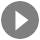
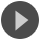

完成搜索，进入待机状态
待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.790024
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=相对原子质量最小的稀有气体是?&q2=&q3=氖+氦+氪&q4=&rn=50
question: 相对原子质量最小的稀有气体是?
('B', '氦', 1.9018330575199798)
('C', '氪', 0.2815164765052032)
('A', '氖', 0.15676829405128956)


完成搜索，进入待机状态
待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.265058
正在等待答题框出现，答题框相似度: 0.221446
正在等待答题框出现，答题框相似度: 0.151815
正在等待答题框出现，答题框相似度: 0.235856
正在等待答题框出现，答题框相似度: 0.226434
正在等待答题框出现，答题框相似度: 0.199557
正在等待答题框出现，答题框相似度: 0.214228
正在等待答题框出现，答题框相似度: 0.770567
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=毛泽东诗句“虎踞龙盘今胜昔"说的是哪个城市?&q2=&q3=长沙+贵阳+南京&q4=&rn=50
question: 毛泽东诗句“虎踞龙盘今胜昔"说的是哪个城市?
('C', '南京', 1.9843597412109375)
('A', '长沙', 0)
('B', '贵阳', 0)


完成搜索，进入待机状态
待机中，按回车键继续，按q退出

进入等待状态……
正在等待答题框出现，答题框相似度: 0.218916
正在等待答题框出现，答题框相似度: 0.231622
正在等待答题框出现，答题框相似度: 0.203084
正在等待答题框出现，答题框相似度: 0.203231
正在等待答题框出现，答题框相似度: 0.786702
发现答题框，正在等待题目文字显示完成……
正在解析……
Parsing pic...
http://www.baidu.com/s?q1=一般来说树枝上哪部分叶子最后枯落?&q2=&q3=树干+靠近+部分+树枝中部+树梢部分&q4=&rn=50
question: 一般来说树枝上哪部分叶子最后枯落?
('A', '靠近树干部分', 1.998046874067768)
('C', '树梢部分', 1.4931001053018917)
('B', '树枝中部', 1.0019531250004547)


完成搜索，进入待机状态
待机中，按回车键继续，按q退出
q


In [17]:
game = 'baiwan'
engine = 'baidu'

STATE_STANDBY = 0
STATE_PARSING = 1
STATE_COOLDOWN = 2

state = STATE_COOLDOWN

if game == 'baiwan':
    questionbox_template = cv2.imread('template_baiwan.jpg')

while True:
    if state == STATE_STANDBY:
        im = capture_img()
        
        match = cv2.matchTemplate(im,
            questionbox_template,
            cv2.TM_CCOEFF_NORMED)
        print('正在等待答题框出现，答题框相似度:', match.max())
        if match.max() > 0.6:
            # 等待文字显示动画完成
            print('发现答题框，正在等待题目文字显示完成……')
            time.sleep(0.5)
            state = STATE_PARSING
        else:
            time.sleep(0.1)
    elif state == STATE_PARSING:
        print('正在解析……')
        im = capture_img()
        
        match = cv2.matchTemplate(im,
            questionbox_template,
            cv2.TM_CCOEFF_NORMED)
#         print(match)
        if match.max() > 0.6:
            ok = search_ans_from_pic(im[:1200,:,:], game=game)
        
            if ok:
                print('完成搜索，进入待机状态')
                state = STATE_COOLDOWN
            else:
                print('未找到答案，重新解析题目文本……')
                time.sleep(0.1)
        else:
            print('答题框消失，进入等待状态')
            state = STATE_STANDBY
    elif state == STATE_COOLDOWN:
        print('待机中，按回车键继续，按q退出')
        ipt = input()
        if ipt != 'q':
            print('进入等待状态……')
            state = STATE_STANDBY
        else:
            break

In [18]:
with open('questions.txt','r') as f:
    i = 0
    for line in f:
        question, opt_a, opt_b, opt_c = map(lambda s:s.strip(), line.split(','))
        search_ans(question, opt_a, opt_b, opt_c)
        time.sleep(1)
        i += 1
        if i > 3:
            break

http://www.baidu.com/s?q1=以下哪个海沟最深?&q2=&q3=&q4=&rn=50
世界上最深的海沟是什么?它在哪个洋?_百度知道 [7, 7, 6] [7.048729124558213, 7.052568256825683, 6.051394983164706]
世界各大洋最深海沟是哪个_百度知道 [7, 7, 6] [13.92600963251999, 13.934684525870518, 11.95444350041779]
最深的海沟马里亚纳海沟位于哪个洋()A、太平洋B、印度洋C..._上学吧 [12, 8, 8] [24.953861033374245, 21.433976775988405, 19.453735750535678]
question: 以下哪个海沟最深?
('A', '马里亚纳海沟', 60.57339556490939)
('B', '波多黎各海沟', 51.401147486097564)
('C', '菲律宾海沟', 51.174424748193935)


http://www.baidu.com/s?q1=“桃李满天下”中的“桃李”一般用来指代?&q2=&q3=&q4=&rn=50
为什么用“桃李”指代学生_百度知道 [0, 2, 0] [0.0, 2.008258057321289, 0.0]
"桃李满天下"中的"桃李"是什么意思??_百度知道 [0, 2, 0] [0.0, 3.902163718053103, 0.0]
令公桃李满天下这句诗什么意思?用了什么样的修辞手法?_百度知道 [1, 1, 0] [0.9096222025846216, 4.819592966454938, 0.0]
question: “桃李满天下”中的“桃李”一般用来指代?
('B', '学生', 16.667370464478328)
('A', '老师', 2.8402268848389256)
('C', '前辈', 0.0)


http://www.baidu.com/s?q1=食用适量的海苔可以预防甲状腺肿大是因为海苔中的哪种元素?&q2=&q3=&q4=&rn=50
海苔健康营养价值有哪些 海苔食用注意事项及作用_百度知道 [0, 0, 0] [0.0, 0.0, 0.0]
多吃海带能预防甲状腺肿大是因为其中富含哪种元素?_百度知道 [0, 0, 0] [0.0, 0.0, 0.0]
宝妈可以吃海苔吗,影响BB吃人奶吗_百度知道 [0, 0, 0] [0.0, 0.0, 0.0]
question: 食用适量的海苔可以预防甲状腺肿大是因为海苔中的哪种元素?
('A', '钙', 0.0)
('B', '碘', 0.0)
('C', '锌', 0.0)


http://www.baidu.com/s?q1=《马里奥》系列游戏中马里奥吃哪种植物可以体积变大?&q2=&q3=&q4=&rn=50
《超级马里奥兄弟》中马里奥可以通过吃什么来长大?_百度知道 [2, 0, 0] [2.0039192867039435, 0.0, 0.0]
马里奥吃什么变大_百度知道 [1, 0, 0] [2.8924397700998337, 0.0, 0.0]
NDS《超级马里奥》系列游戏推荐下载 _NDS掌机站_NDS.DUOWAN.COM [1, 0, 0] [3.7754848093219233, 0.0, 0.0]
question: 《马里奥》系列游戏中马里奥吃哪种植物可以体积变大?
('A', '蘑菇', 6.323608340091091)
('B', '土豆', 0.0)
('C', '西红柿', 0.0)
